# wk12 Demo - Streaming in Spark - Online Learning
**MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2018**

Throughout the course we've focused on batch learning. Where we take data in a batch and process it in order to train a model and provide predictions. Online learning instead focuses on streaming data in and training a model as we get more data. There are trade-offs between batch and online model training such as the amount of effort required to maintain state in Spark. Databricks and the general Spark community have spent a large amount of effort to bring Structured Streaming to Spark in a clean API.

This class will have less theory and we'll focus on online learning for two algorithms we've covered so far. Naive Bayes and K-means.

By the end of today's demo you should be able to:

- ... **describe** a situation where you would want to leverage online learning
- ... **implement** a simple streaming pipeline.
- ... **explain** the complexities that come along with streaming processes

**NOTE** None

**Additional Resources:** This notebook was based on the following references:

- [Real-Time End-to-End Integration with Apache Kafka in Apache Spark’s Structured Streaming](https://databricks.com/blog/2017/04/04/real-time-end-to-end-integration-with-apache-kafka-in-apache-sparks-structured-streaming.html)
- [Introducing Stream-Stream Joins in Apache Spark 2.3](https://databricks.com/blog/2018/03/13/introducing-stream-stream-joins-in-apache-spark-2-3.html)
- [Streaming K-means Example](https://github.com/apache/spark/blob/master/examples/src/main/python/mllib/streaming_k_means_example.py)
- https://www.kaggle.com/c/avazu-ctr-prediction/data
- https://community.cloudera.com/t5/Data-Ingestion-Integration/No-brokers-found-in-ZK/td-p/40952
- https://github.com/dpkp/kafka-python


**Spark summit 2019** - PySpark streaming video tutorial:
- https://databricks.com/session/writing-continuous-applications-with-structured-streaming-pyspark-api

## Topics in Streaming

- continuous vs minibatch
- latency vs throughput
    - real-time
    - near real-time
    - some-time
    

- processing time vs event time
    - triggers
    - watermarks
    

- windows
    - fixed
    - sliding
    - sessions
    

- joins
    - stream-stream joins
    - stream-static joins

## Notebook Setup

In [1]:
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import StreamingKMeans
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
PACKAGES = ['org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4']
os.environ['PYSPARK_SUBMIT_ARGS'] = f"--packages {','.join(PACKAGES)} pyspark-shell"
print(os.environ['PYSPARK_SUBMIT_ARGS'])

--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4 pyspark-shell


In [3]:
!sudo service kafka-server start

Starting Kafka Server (kafka-server):[  OK  ]
Kafka Server is running[  OK  ]


In [6]:
!ps -ef|grep spark-sql-kafka

root     26741 26678 44 18:48 ?        00:00:19 /usr/java/jdk1.8.0_131/bin/java -cp /opt/spark/conf/:/opt/spark/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.app.name=wk13_demo --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4 pyspark-shell
root     26847 26678  0 18:49 pts/1    00:00:00 /bin/sh -c ps -ef|grep spark-sql-kafka
root     26849 26847  0 18:49 pts/1    00:00:00 grep spark-sql-kafka


In [4]:
from pyspark.sql import SparkSession
app_name = "wk13_demo"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [7]:
spark

In [32]:
spark.stop()

## Message Brokers and the Pub/Sub model(Kafka)

Message brokers break apart dependencies between applications by creating an asynchronous queue between potions of the application. This can be powerful for breaking machine learning functionality away from the core components of an application.

In this model your application sends event messages to a message broker over some protocol such as TCP or UDP. In most cases you want to use TCP so you have acknowledgement of receipt.

By breaking away the model from the application you can offload the compute associated with predictions and many other possibilites in case you don't need predictions right away.

Here the application is your publisher while your model code acts as a subscriber waiting for new data, thus the name Pub/Sub.

One of the most popular frameworks for implemeneting Pub/Sub capabilities is Kafka. It is part of the Apache Software Foundation and integrates well with the rest of the Apache projects such as Spark.

Some of the managed cloud alternatives would be Kinesis (AWS), Pub/Sub (Google), and Event Hub (Azure).

## Online Advertising
Stream-Stream joins were introduced in Spark 2.3 and have enabled Spark to be used for classes of problems involving two streams. A common example is Online advertising where you have ad impressions and ad clicks.

Both clicks and impressions can have delays in sending messages to the broker system such as if a person is sitting on a page and then clicks an ad, or if a user has intermittent connectivity issues. This means we need to store messages for some reasonable period of time from each stream to wait for the corresponding streams message. This is called watermarking and is outlined below.

What we would like to do is given a site and an ad exchange that we send ads through, predict the likelihood of our ad being clicked, aka potentially generating revenue. In the example below we'll seed a click with a given probability and if Naive Bayes does a good job we should end up with the same probability at the end of our training. 

**Watermarks**: Watermarking in Structured Streaming is a way to limit state in all stateful streaming operations by specifying how much late data to consider. Specifically, a watermark is a moving threshold in event-time that trails behind the maximum event-time seen by the query in the processed data. The trailing gap (aka watermark delay) defines how long should the engine wait for late data to arrive and is specified in the query using withWatermark. Read about it in more detail in our previous blog post on streaming aggregations. For our stream-stream inner joins, you can optionally specify the watermark delay but you must specify to limit all state on both streams.

### Click Through Rate Prediction
* For each impression, we will have a site name, an exchange name and whether a user clicked or not
    * For instance, "Yahoo.com, AdX, 1"
* Bayes' law says that $P(\text{click} | \text{site}, \text{exchange}) = \frac{P(\text{site}, \text{exchange} | \text{click}) P(\text{click})}{P(\text{site}, \text{exchange})}$
* Naive Bayes says that we can assume conditional independence, meaning that $P(\text{site}|\text{click}) * P(\text{exchange}|\text{click}) = P(\text{site}, \text{exchange}|\text{click})$
    * Recall that we don't need to keep track of the denominator
* In order to build a NB model, we need to keep track of the following:
    * $P(\text{site}|\text{click})$
    * $P(\text{exchange}|\text{click})$
    * $P(\text{click})$
* At inference time, we will be predicting 
    * $\text{argmax}_{\text{click} \in {0, 1}} P(\text{site} | \text{click}) * P(\text{exchange} | \text{click}) *  P(\text{click})$

### Setup Data Stream

In [36]:
!kafka-topics --zookeeper localhost:2181 --delete --topic impressions
!kafka-topics --zookeeper localhost:2181 --delete --topic clicks

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/kafka/libs/slf4j-log4j12-1.7.21.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/kafka/libs/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Topic impressions is marked for deletion.
Note: This will have no impact if delete.topic.enable is not set to true.
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/kafka/libs/slf4j-log4j12-1.7.21.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/kafka/libs/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory

In [37]:
impressions = spark.readStream.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").\
    option("subscribe", "impressions").load()   
clicks = spark.readStream.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").\
    option("subscribe", "clicks").load()   

### CTR to sample by exchange and site. 
If NB preforms well our predictions will be close to these values.

In [10]:
!cat click_through_rate_config.json

{
	"site_exchange_ctr": {
		"yahoo.com+AdX": 0.4,
		"yahoo.com+SpotX": 0.2,
		"cnn.com+AdX": 0.6,
		"cnn.com+SpotX": 0.3
	}
}

### Watermarking and left outer join to keep non-clicked Ads

In [38]:
impressionsWithWatermark = impressions \
    .selectExpr("split(value,',')[0] as impressionAdId", \
                "split(value,',')[1] as site", \
                "split(value,',')[2] as exchange",
                "timestamp as impressionTime") \
    .withWatermark("impressionTime", "5 second") 

clicksWithWatermark = clicks \
    .selectExpr("split(value,',')[0] AS clickAdId", \
                "timestamp as clickTime") \
    .withWatermark("clickTime", "5 second")

statsLog = impressionsWithWatermark\
    .join(clicksWithWatermark,
            expr("""
                clickAdId = impressionAdId AND
                clickTime >= impressionTime AND
                clickTime <= impressionTime + interval 5 second
                """),
            "leftOuter"
         )

statsLog.createOrReplaceTempView("statsLog")

### Generate Data

In [52]:
os.system("python kafka_impression_stream.py &")
os.system("python kafka_click_stream.py &")

0

In [53]:
priorsData = spark.sql("""
          select 
              site, 
              exchange, 
              if(clickAdId is not null, 1, 0) as is_click,
              count(1) as count
          from statslog
          group by 
              site, 
              exchange,
              if(clickAdId is not null, 1, 0)
          """) 

## write to console
query = priorsData\
    .writeStream \
    .format("console")\
    .outputMode("complete")\
    .option("truncate","false")\
    .trigger(processingTime='15 seconds')\
    .start()

## write to mem
queryMem = priorsData \
    .writeStream \
    .queryName("priorsData") \
    .outputMode("complete") \
    .format("memory") \
    .trigger(processingTime='15 seconds') \
    .start()

In [54]:
time.sleep(160 + 15) ## stops when close to done 

In [55]:
query.stop()
queryMem.stop()

#### Output from Command Line

```
-------------------------------------------
quickstart.cloudera_1  | Batch: 0
quickstart.cloudera_1  | -------------------------------------------
quickstart.cloudera_1  | +----+--------+--------+-----+
quickstart.cloudera_1  | |site|exchange|is_click|count|
quickstart.cloudera_1  | +----+--------+--------+-----+
quickstart.cloudera_1  | +----+--------+--------+-----+
quickstart.cloudera_1  |
19/12/02 19:11:24 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 15000 milliseconds, but spent 21668 milliseconds
-------------------------------------------
quickstart.cloudera_1  | Batch: 1
quickstart.cloudera_1  | -------------------------------------------
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |site     |exchange|is_click|count|
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |yahoo.com|SpotX   |1       |3    |
quickstart.cloudera_1  | |cnn.com  |SpotX   |1       |10   |
quickstart.cloudera_1  | |yahoo.com|AdX     |1       |16   |
quickstart.cloudera_1  | |cnn.com  |AdX     |1       |24   |
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  |
quickstart.cloudera_1  | 19/12/02 19:11:33 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 15000 milliseconds, but spent 18021 milliseconds
19/12/02 19:11:42 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 15000 milliseconds, but spent 17970 milliseconds
-------------------------------------------
quickstart.cloudera_1  | Batch: 2
quickstart.cloudera_1  | -------------------------------------------
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |site     |exchange|is_click|count|
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |yahoo.com|SpotX   |1       |4    |
quickstart.cloudera_1  | |cnn.com  |SpotX   |1       |13   |
quickstart.cloudera_1  | |yahoo.com|AdX     |1       |17   |
quickstart.cloudera_1  | |cnn.com  |AdX     |1       |28   |
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  |
quickstart.cloudera_1  | 19/12/02 19:11:51 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 15000 milliseconds, but spent 18183 milliseconds
19/12/02 19:11:59 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 15000 milliseconds, but spent 16589 milliseconds
[Stage 88:>(79 + 6) / 200][Stage 90:>   (0 + 0) / 1][Stage 91:>   (0 + 0) / 1][I 19:12:01.592 LabApp] Saving file at /LiveSessionMaterials/wk13Demo_Streaming/Spark_Streaming_Naive_Bayes.ipynb
quickstart.cloudera_1  | [W 19:12:01.594 LabApp] Notebook LiveSessionMaterials/wk13Demo_Streaming/Spark_Streaming_Naive_Bayes.ipynb is not trusted
-------------------------------------------
quickstart.cloudera_1  | Batch: 3
quickstart.cloudera_1  | -------------------------------------------
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |site     |exchange|is_click|count|
quickstart.cloudera_1  | +---------+--------+--------+-----+
quickstart.cloudera_1  | |yahoo.com|SpotX   |1       |4    |
quickstart.cloudera_1  | |cnn.com  |SpotX   |1       |13   |
quickstart.cloudera_1  | |yahoo.com|AdX     |1       |17   |
quickstart.cloudera_1  | |cnn.com  |SpotX   |0       |47   |
quickstart.cloudera_1  | |yahoo.com|AdX     |0       |49   |
quickstart.cloudera_1  | |yahoo.com|SpotX   |0       |53   |
quickstart.cloudera_1  | |cnn.com  |AdX     |1       |28   |
quickstart.cloudera_1  | |cnn.com  |AdX     |0       |40   |
quickstart.cloudera_1  | +---------+--------+--------+-----+
```

### Show Data after streaming for a bit
We would predict on an interval and bring in data from the stream to calculate each update. Here we'll walk through it in 1 step.

In [56]:
data = spark.sql("select * from priorsData")

In [57]:
data.show()

+---------+--------+--------+-----+
|     site|exchange|is_click|count|
+---------+--------+--------+-----+
|yahoo.com|   SpotX|       1|    4|
|  cnn.com|   SpotX|       1|   13|
|yahoo.com|     AdX|       1|   17|
|  cnn.com|   SpotX|       0|   47|
|yahoo.com|     AdX|       0|   41|
|yahoo.com|   SpotX|       0|   53|
|  cnn.com|     AdX|       1|   28|
|  cnn.com|     AdX|       0|   32|
+---------+--------+--------+-----+



In [58]:
df = data.toPandas()

In [59]:
## P(click)
p_click = df.groupby(['is_click']).sum()
p_click

,count
is_click,
0,173
1,62


In [60]:
## P(site | click)
p_site_click = df.groupby(['site', 'is_click']).sum()
p_site_click

count
site      is_click       
cnn.com   0            79
          1            41
yahoo.com 0            94
          1            21

In [61]:
## P(exchange | click)
p_exchange_click = df.groupby(['exchange', 'is_click']).sum()
p_exchange_click

count
exchange is_click       
AdX      0            73
         1            45
SpotX    0           100
         1            17

### Let's build our NB model

In [62]:
class NB:
    def __init__(self, p_click, p_site_click, p_exchange_click):
        self.p_click = p_click.astype(np.float)
        self.p_site_click = p_site_click.astype(np.float)
        self.p_exchange_click = p_exchange_click.astype(np.float)
    
    def classify(self, site, exchange):
        p_numerator_click = (self.p_site_click.loc[site].loc[1] / self.p_click.loc[1])\
            * (self.p_exchange_click.loc[exchange].loc[1] / self.p_click.loc[1])\
            * (self.p_click.loc[1] / np.sum(self.p_click))
        p_numerator_nonclick = (self.p_site_click.loc[site].loc[0] / self.p_click.loc[0])\
            * (self.p_exchange_click.loc[exchange].loc[0] / self.p_click.loc[0])\
            * (self.p_click.loc[0] / np.sum(self.p_click))
        print("estimate of clicks to non-clicks: (%.3f):(%.3f)" % (p_numerator_click, p_numerator_nonclick))
        return float(p_numerator_click / (p_numerator_click + p_numerator_nonclick))

In [63]:
!cat click_through_rate_config.json

{
	"site_exchange_ctr": {
		"yahoo.com+AdX": 0.4,
		"yahoo.com+SpotX": 0.2,
		"cnn.com+AdX": 0.6,
		"cnn.com+SpotX": 0.3
	}
}

In [65]:
nb = NB(p_click, p_site_click, p_exchange_click)

print("yahoo.com+AdX",nb.classify(site="yahoo.com", exchange="AdX"))
print("yahoo.com+SpotX",nb.classify(site="yahoo.com", exchange="SpotX"))
print("cnn.com+AdX",nb.classify(site="cnn.com", exchange="AdX"))
print("cnn.com+SpotX",nb.classify(site="cnn.com", exchange="SpotX"))

estimate of clicks to non-clicks: (0.065):(0.169)
yahoo.com+AdX 0.277597129704939
estimate of clicks to non-clicks: (0.025):(0.231)
yahoo.com+SpotX 0.0958187045136147
estimate of clicks to non-clicks: (0.127):(0.142)
cnn.com+AdX 0.4716515525187701
estimate of clicks to non-clicks: (0.048):(0.194)
cnn.com+SpotX 0.1975503824660335


**Note**: NB's conditional independence assumption made the estimation inaccurate; however they're roughly within 10% of the known click through rate.

## K-means Streaming

Since K-means is unsupervised and each point can be added into the model additivly it is a great example of an online model.

In this simple example we're going to take some sample data in 2 clusters and bring in new data and let the cluster centers evolve based on the new data.

In [27]:
%%writefile kmeans_data
-3.0 -5.0
-5.1 -4.1
-3.9 -5.2
-5.2 -4.5
-3.3 -5.1
4.0 2.0
3.1 5.1
5.2 5.2
4.1 3.5
4.5 4.5

Overwriting kmeans_data


In [28]:
train_data = np.loadtxt("kmeans_data")

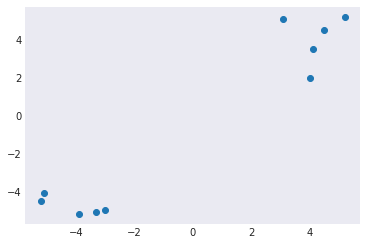

In [29]:
plt.scatter(train_data[:,0], train_data[:,1])

In [30]:
%%writefile kmeans_data_sample
(1.0), [1.7, 0.4]
(2.0), [2.2, 1.8]

Overwriting kmeans_data_sample


In [33]:
# For plotting new points we will stream in
!cat kmeans_data > full_data
!printf "\n1.7 0.4" >> full_data
!printf "\n2.2 1.8" >> full_data

In [35]:
ssc = StreamingContext(sc, 1)

In [36]:
def parse(lp):
    label = float(lp[lp.find('(') + 1: lp.find(')')])
    vec = Vectors.dense(lp[lp.find('[') + 1: lp.find(']')].split(','))

    return LabeledPoint(label, vec)

trainingData = sc.textFile("kmeans_data")\
    .map(lambda line: Vectors.dense([float(x) for x in line.strip().split(' ')]))

testingData = sc.textFile("kmeans_data_sample").map(parse)

In [37]:
trainingQueue = [trainingData]
testingQueue = [testingData]

trainingStream = ssc.queueStream(trainingQueue)
testingStream = ssc.queueStream(testingQueue)

In [38]:
model = StreamingKMeans(k=2, decayFactor=1.0).setRandomCenters(dim=2, weight=1.0, seed=0)
model.trainOn(trainingStream)

In [39]:
result = model.predictOnValues(testingStream.map(lambda lp: (lp.label, lp.features)))
result.pprint() ## will print out values

In [40]:
original_model_centers = model._model.centers
print(original_model_centers)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]


In [41]:
ssc.start()
time.sleep(5)
ssc.stop(stopSparkContext=False)

-------------------------------------------
Time: 2018-08-01 18:43:25
-------------------------------------------
(1.0, 0)
(2.0, 1)

-------------------------------------------
Time: 2018-08-01 18:43:26
-------------------------------------------

-------------------------------------------
Time: 2018-08-01 18:43:27
-------------------------------------------

-------------------------------------------
Time: 2018-08-01 18:43:28
-------------------------------------------

-------------------------------------------
Time: 2018-08-01 18:43:29
-------------------------------------------



In [42]:
print("Original cluster centers")
print(original_model_centers)
print("Updated cluster centers")
print(model._model.centers)

Original cluster centers
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
Updated cluster centers
[[-2.10513538 -3.07140611]
 [ 3.5757476   4.10817864]]


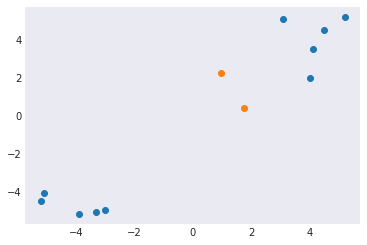

In [56]:
plt.scatter(train_data[:,0], train_data[:,1])
plt.scatter(original_model_centers.transpose()[0], original_model_centers.transpose()[1])

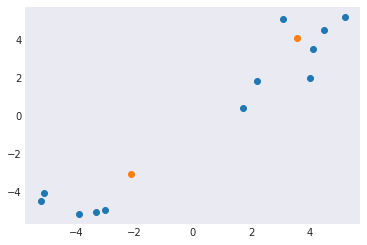

In [57]:
plt.scatter(full_data[:,0], full_data[:,1])
plt.scatter(model._model.centers.transpose()[0], model._model.centers.transpose()[1])

## Discussion

What else could be done to make the Naive Bayes more effective in a real world system?
- How could we checkpoint?
- How can we rollback?
- Other ideas?

What are some examples of systems you would like to apply this to?
- Email Spam (Data trumps complex models, see [The Unreasonable
Effectiveness of Data](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf))
- ...